In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd "/content/drive/MyDrive/ColabTemp"

In [2]:
# %%capture
# !pip install tensorflow==2.10.0

In [3]:
from keras.datasets import mnist, cifar10
from sklearn.preprocessing import OneHotEncoder
import random
import tensorflow as tf
from keras import models, layers
from keras import backend
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import gc
import psutil
import time
import glob
import os
import numpy as np

In [4]:
mySeed = 42
np.random.seed(mySeed)
random.seed(mySeed)
tf.random.set_seed(mySeed)
# torch.manual_seed(mySeed)

In [5]:
def get_memory_usage():
    memory_info = psutil.virtual_memory()
    memory_percent = memory_info.percent
    # memory_free_values = memory_info.available / (1024**3)  # in GB
    return memory_percent

In [6]:
# Hyper parameters

num_clients = 5
batch_size = 8
total_steps = 10

clear_memory_in_percent = 80

lr = 0.01
# optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr, decay=lr/total_steps)
optimizer = "adam"
loss_cce = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
metrics = ["accuracy"]
client_epochs = 1

swap_step = 2
n_swap_between_avg = 2 # plus one to your number, if need 2 swap between avg, enter 3

remain = 0.01 # Remove some data for running faster in test

In [7]:
passed_steps = 0
is_mnist_dataset = False
model_type = "conv" # 'mlp' or 'conv'
is_print_eval = False
start_bold = "\033[1m"
end_bold = "\033[0;0m"
save_file_name_pre = f"fs_{num_clients}_{total_steps}_{swap_step}_{n_swap_between_avg}_step"

if is_mnist_dataset:
    running_dataset = mnist
else:
    running_dataset = cifar10

dataset_name = str(running_dataset).split("'")[1].split(".")[-1]
running_method = f"{dataset_name}_{model_type}"

## Load Data

In [8]:
(x_train, y_train), (x_test, y_test) = running_dataset.load_data()

# Normalize data
x_train, x_test = x_train/255, x_test/255

# OneHotEncoded Labels
oneHotEncoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
y_train = oneHotEncoder.fit_transform(y_train.reshape(-1, 1))
y_test = oneHotEncoder.transform(y_test.reshape(-1, 1))

print(f"Train x={x_train.shape}, y={y_train.shape}")
print(f"Test x={x_test.shape}, y={y_test.shape}")

Train x=(50000, 32, 32, 3), y=(50000, 10)
Test x=(10000, 32, 32, 3), y=(10000, 10)


In [9]:
# Remove some data for running faster in test
x_train = x_train[:int(x_train.shape[0]*remain)]
y_train = y_train[:int(y_train.shape[0]*remain)]
x_test = x_test[:int(x_test.shape[0]*remain)]
y_test = y_test[:int(y_test.shape[0]*remain)]

print(f"Train x={x_train.shape}, y={y_train.shape}")
print(f"Test x={x_test.shape}, y={y_test.shape}")

Train x=(500, 32, 32, 3), y=(500, 10)
Test x=(100, 32, 32, 3), y=(100, 10)


In [10]:
def create_clients_with_data_assignment(values_list, label_list, num_clients=10, initial="client"):
    """ return: A dictionary with the customer id as the dictionary key and the value
                will be the data fragment - tuple of values and labels.
        args:
            values_list: a numpy array object with the values
            label_list: list of binarized labels (one-hot encoded)
            num_clients: number of customers (clients)
            initial: the prefix of the clients, e.g., client_1
     """

    # create list of client names
    client_names = [f"{initial}_{i+1}" for i in range(num_clients)]

    # shuffle the data
    data = list(zip(values_list, label_list))
    random.shuffle(data)

    # shard the data and split it for each customer
    size = len(data) // num_clients
    shards = [data[i: i+size]  for i in range(0, size*num_clients, size)]

    # Check if the fragment number is equal to the number of clients
    assert(len(shards) == len(client_names))

    return {client_names[i]: shards[i]  for i in range(len(client_names))}

In [11]:
def batch_data(data_shard, batch_size=32):
    """ Receives a piece of data (values, labels) from a client and creates a tensorflow Dataset object in it
        args:
            data_shard: values and labels that make up a customer's data shard
            batch_size: batch size
        return:
            data tensorflow Dataset object
    """
    #seperate shard into data and labels lists
    values, labels = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(values), list(labels)))
    return dataset.shuffle(len(labels), reshuffle_each_iteration=False).batch(batch_size)


### Explaining the function with example ###
# test = list(zip([[1, 2], [3, 4], [5, 6], [7, 8]], ["a", "b", "c", "d"]))
# print(test)
# data, label = zip(*test)
# print(data)
# print(label)

# dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
# test1 = dataset.shuffle(len(label))
# print(list(test1.as_numpy_iterator()))
# test2 = dataset.shuffle(len(label)).batch(3)
# print(list(test2.as_numpy_iterator()))
# list(test2)[0][0].shape

In [12]:
# Create clients and batched data

clients = create_clients_with_data_assignment(x_train, y_train, num_clients=num_clients, initial="client")

# Bached data with tensorflow data object
clients_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data, batch_size)

test_batch_size = len(y_test)
# Convert test data to tensorflow data object
test_batched = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(test_batch_size)

## Training

In [13]:
def scale_model_weights(weight, scalar):
    """ Scale the model weights """

    weight_final = []
    for i in range(len(weight)):
        weight_final.append(weight[i] * scalar)

    return weight_final

In [14]:
def sum_scaled_weights(scaled_weight_list):
    """ Return the sum of the listed scaled weights.
        axis_O is equivalent to the average weight of the weights """

    avg_weights = list()
    # get the average gradient accross all client gradients
    for gradient_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(gradient_list_tuple, axis=0)
        avg_weights.append(layer_mean)

    return avg_weights


### Explaining the function with example ###
# t = [[[[2, 3],[3, 4]], [[3, 4],[4, 5]], [[4, 5],[5, 6]]],
#      [[[5, 6],[6, 7]], [[6, 7],[7, 8]], [[7, 8],[8, 9]]]]
# for y in zip(*t):
#     print(y)
#     print(tf.math.reduce_sum(y, axis=0))

In [15]:
def test_global_model(x_test, y_test, model, loss_func):
    y_pred = model.predict(x_test, verbose=0)
    loss = loss_func(y_test, y_pred)

    acc = accuracy_score(tf.argmax(y_test, axis=1), tf.argmax(y_pred, axis=1))

    return acc, loss.numpy()

In [16]:
class Neural_Network:
    @staticmethod
    def mnist_mlp(shape, classes):
        model = models.Sequential([
            layers.Flatten(input_shape=shape),
            layers.Dense(100, activation="relu"),
            layers.Dense(99, activation="relu"),
            layers.Dense(classes, activation="softmax"),
            ])

        return model

    @staticmethod
    def mnist_conv(shape, classes):
        model = models.Sequential([
            # layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1), strides=(1, 1), padding="valid"),
            layers.Conv2D(32, (3, 3), activation="relu", input_shape=shape+(1,), strides=(1, 1), padding="valid"),
            layers.MaxPool2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation="relu"),
            layers.Flatten(),
            layers.Dense(classes, activation="softmax"),
            ])

        return model
    

    @staticmethod
    def cifar10_mlp(shape, classes):
        model = models.Sequential([
            layers.Flatten(input_shape=shape),
            layers.Dense(256, activation="relu"),
            layers.Dense(128, activation="relu"),
            layers.Dense(64, activation="relu"),
            layers.Dense(classes, activation="softmax")])

        return model

    @staticmethod
    def cifar10_conv(shape, classes):
        model = models.Sequential([
            # layers.Conv2D(32, (3, 3), activation="relu", input_shape=(32, 32, 3), strides=(1, 1), padding="valid"),
            layers.Conv2D(32, (3, 3), activation="relu", input_shape=shape, strides=(1, 1), padding="valid"),
            layers.MaxPool2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation="relu"),
            layers.MaxPool2D(),
            layers.Flatten(),
            layers.Dense(100, activation="relu"),
            layers.Dense(classes, activation="softmax"),
            ])

        return model

In [17]:
# Initialize all clients with same weight
global_history = {"times": {"train":list(), "swap":list(), "step":list()},
                  "accuracy": list(),
                  "loss": list()}
nn_global = Neural_Network()
model_method = getattr(nn_global, running_method)
global_model = model_method(x_train.shape[1:], y_train.shape[-1])
global_weights = global_model.get_weights()

client_select = list(clients_batched.keys())
client_weights = dict.fromkeys(client_select, global_weights)

# Load saved state & log
last_saved = sorted(glob.glob(f"{save_file_name_pre}_*.npz"), key=os.path.getmtime)
if last_saved:
    last_saved = last_saved[-1]
    passed_steps = int(last_saved.split("_")[-1].split(".")[0]) + 1

    npzFile = np.load(last_saved, allow_pickle=True)
    client_weights = npzFile["client_weights"].item()
    global_history = npzFile["global_history"].item()
    random_state = tuple(npzFile["random_state_ndarray"])
    np_random_state = tuple(npzFile["np_random_state_ndarray"])
    npzFile.close()

    random.setstate(random_state)
    np.random.set_state(np_random_state)

In [18]:
def fed_swap(client):
    random_num = random.randint(0, len(client_select)-1)
    random_client = client_select[random_num]

    temp_weight = client_weights[random_client]
    client_weights[random_client] = client_weights[client]

    return temp_weight

In [19]:
def fed_avg():
    # calculate total training data across clients
    # if all clients have a same length
    local_count = len(clients[client_select[0]])
    global_count = local_count * len(client_select)
    scaling_factor = local_count / global_count

    # initial list to collect clients weight after scalling
    scaled_clients_weight_list = list()
    
    for client in client_select:
        scaled_weights = scale_model_weights(client_weights[client], scaling_factor)
        scaled_clients_weight_list.append(scaled_weights)

    # to get the average over all the clients model, we simply take the sum of the scaled weights
    avg_weights = sum_scaled_weights(scaled_clients_weight_list)

    return avg_weights

In [20]:
def print_log(training_time, swapping_time, step_time, step, metric_index):
    print(f"round: {step} | training_time: {training_time:.2f}s | swapping_time: {swapping_time:.2f}s | step_time: {step_time:.2f}s")

    global is_print_eval
    if is_print_eval:
        is_print_eval = False
        print(f"round: {step} / global_acc: {start_bold}{global_history['accuracy'][metric_index]:.4%}{end_bold} / global_loss: {start_bold}{global_history['loss'][metric_index]:.4f}{end_bold}\n")

In [21]:
def print_prev_log(passed_steps):
    if passed_steps:
        global is_print_eval
        metric_index = -1

        for step in range(passed_steps):
            if (step % (swap_step*n_swap_between_avg) == 0):
                is_print_eval = True
                metric_index += 1

            training_time = global_history["times"]["train"][step]
            swapping_time = global_history["times"]["swap"][step]
            step_time = global_history["times"]["step"][step]
            print_log(training_time, swapping_time, step_time, step, metric_index)

In [22]:
def save_state_and_log(step):
    if step != 0:
        os.remove(f"{save_file_name_pre}_{step-1}.npz")
    
    random_state = random.getstate()
    np_random_state = np.random.get_state()
    random_state_ndarray = np.array(random_state, dtype=object)
    np_random_state_ndarray = np.array(np_random_state, dtype=object)

    np.savez_compressed(f"{save_file_name_pre}_{step}.npz", client_weights=client_weights, global_history=global_history,
             random_state_ndarray=random_state_ndarray, np_random_state_ndarray=np_random_state_ndarray)

In [23]:
print_prev_log(passed_steps)
for step in range(passed_steps, total_steps):
    training_time_start = time.time()
    for client in client_select:
        nn_local = Neural_Network()
        model_method = getattr(nn_local, running_method)
        local_model = model_method(x_train.shape[1:], y_train.shape[-1])
        local_model.compile(optimizer=optimizer, loss=loss_cce, metrics=metrics)

        local_model.set_weights(client_weights[client])
        local_model.fit(clients_batched[client], epochs=client_epochs, verbose=0)
        client_weights[client] = local_model.get_weights()

        backend.clear_session()
        del nn_local
        del local_model

        if get_memory_usage() > clear_memory_in_percent:
            gc.collect()
    
    training_time = time.time() - training_time_start
    global_history["times"]["train"].append(training_time)

    swapping_time_start = time.time()
    if (step % swap_step == 0) and (step % (swap_step*n_swap_between_avg) != 0):
        for client in client_select:
            client_weights[client] = fed_swap(client)
    
    swapping_time = time.time() - swapping_time_start
    global_history["times"]["swap"].append(swapping_time)

    if (step % (swap_step*n_swap_between_avg) == 0):
        avg_weights = fed_avg()
        client_weights = dict.fromkeys(client_select, avg_weights)

        # update global model
        global_model.set_weights(avg_weights)

        is_print_eval = True
        # test global model and print out metrics after each ...... round
        for (x_test, y_test) in test_batched:
            global_acc, global_loss = test_global_model(x_test, y_test, global_model, loss_cce)
            global_history["accuracy"].append(global_acc)
            global_history["loss"].append(global_loss)

    step_time = time.time() - training_time_start
    global_history["times"]["step"].append(step_time)
    print_log(training_time, swapping_time, step_time, step, -1)
    save_state_and_log(step)

round: 0 | training_time: 11.81s | swapping_time: 0.00s | step_time: 12.66s
round: 0 / global_acc: 6.0000% / global_loss: 2.2948

round: 1 | training_time: 8.37s | swapping_time: 0.00s | step_time: 8.37s
round: 2 | training_time: 11.25s | swapping_time: 0.00s | step_time: 11.25s
round: 3 | training_time: 7.88s | swapping_time: 0.00s | step_time: 7.88s
round: 4 | training_time: 8.04s | swapping_time: 0.00s | step_time: 8.58s
round: 4 / global_acc: 21.0000% / global_loss: 2.1562

round: 5 | training_time: 7.83s | swapping_time: 0.00s | step_time: 7.83s
round: 6 | training_time: 8.37s | swapping_time: 0.00s | step_time: 8.37s
round: 7 | training_time: 7.76s | swapping_time: 0.00s | step_time: 7.76s
round: 8 | training_time: 9.93s | swapping_time: 0.00s | step_time: 10.71s
round: 8 / global_acc: 28.0000% / global_loss: 1.9886

round: 9 | training_time: 11.17s | swapping_time: 0.00s | step_time: 11.17s


## Result

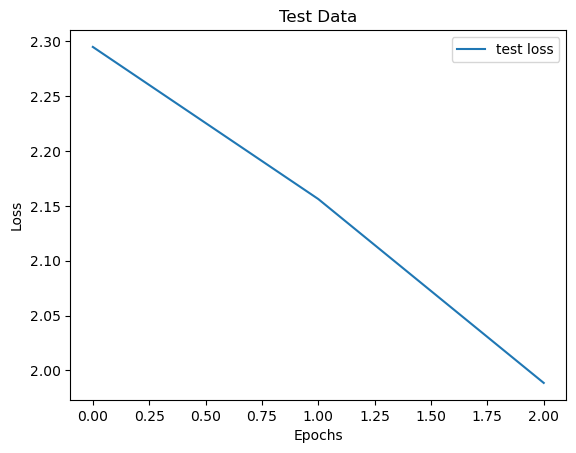

In [24]:
plt.plot(global_history["loss"], label="test loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Test Data")
plt.legend()
plt.show()

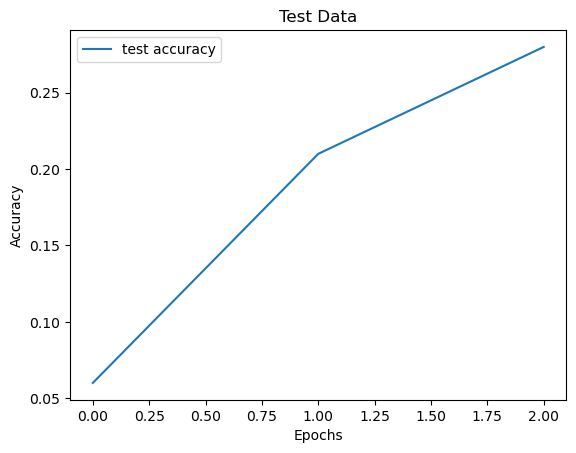

In [25]:
plt.plot(global_history["accuracy"], label="test accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Test Data")
plt.legend()
plt.show()

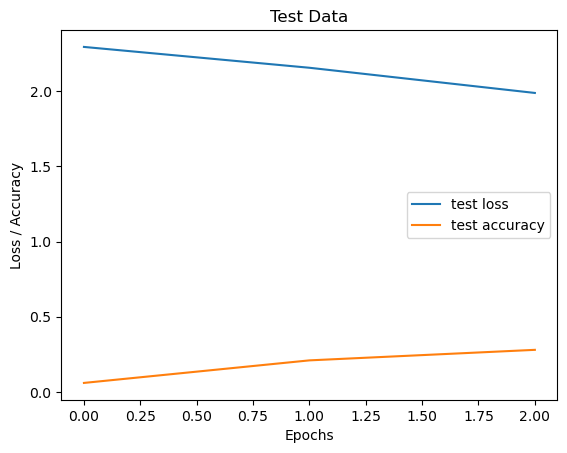

In [26]:
plt.plot(global_history["loss"], label="test loss")
plt.plot(global_history["accuracy"], label="test accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss / Accuracy")
plt.title("Test Data")
plt.legend()
plt.show()